In [18]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from mdfmodels import mdfmodels, fit, utils
from schwimmbad import MultiPool
from dynesty import plotting as dyplot

# import warnings; warnings.simplefilter("once") # this doesn't do what I think it does..

# Fitting MDF models

I use `dynesty` https://arxiv.org/abs/1904.02180 to do dynamic nested sampling to infer the posterior by default.

This is much slower than MCMC like emcee, but pretty foolproof. It also calculates the Bayesian evidence.
It's a pretty neat algorithm. Basically, you start with random points from the prior (using a "prior transform"), calculate the likelihood for every point, then iteratively throw out the lowest likelihood point (and add it to your samples, with a weight based on the likelihood) and sample one with strictly higher likelihood from the prior.
Yuan-Sen Ting describes this as "ruling out prior volume" rather than "finding the peak and sampling" as a usual MCMC algorithm would work. It costs about 10x as much as MCMC, but is good at finding multiple modes.
It's probably overkill for these simple two-parameter models, but I just learned how it works and like it, so you get to suffer/benefit.
The code `mdfmodels.fit` has the loglikelihoods for the models if you want to write your own (faster?) fitter.

The upshot is that unlike MCMC, if you set a very large prior, it will take a long time to find the answer.

# Simple leaky box example

Here we will give a simple example of fitting a leaky box model to randomly generated data.

Note: data errors are *not* accounted for right now.

In [2]:
# Generate fake data
np.random.seed(230589)
N = 100
p = 0.05
data = utils.sample_leaky_box(N, p)

Assuming feh is linearly spaced
Setting cdf first point to 0


Text(0.5, 0, '[Fe/H]')

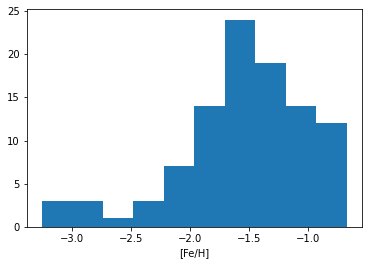

In [3]:
plt.hist(data, bins='auto');
plt.xlabel("[Fe/H]")

In [4]:
# this step takes a minute or two because dynesty is kinda slow. There's ways to optimize that I haven't found yet
with MultiPool(4) as pool:
    output = fit.fit_leaky_box(data, logpmin=-2, logpmax=-1,
                              pool=pool)

16221it [00:56, 287.19it/s, batch: 12 | bound: 0 | nc: 1 | ncall: 126742 | eff(%): 12.798 | loglstar: -75.013 < -73.330 < -73.441 | logz: -75.503 +/-  0.069 | stop:  0.828]      


In [5]:
# The output is a DynamicNestedSampler object, the results are here
res = output.results

Importantly, dynesty returns *weighted* samples of the posterior. If you want to get the equally-weighted samples like a usual MCMC, you need to resample using the weights. This is easy in dynesty:

In [6]:
res.keys()

dict_keys(['niter', 'ncall', 'eff', 'samples', 'samples_id', 'samples_batch', 'samples_it', 'samples_u', 'samples_n', 'logwt', 'logl', 'logvol', 'logz', 'logzerr', 'information', 'batch_nlive', 'batch_bounds', 'bound', 'bound_iter', 'samples_bound', 'scale'])

In [7]:
# dyplot.resample_equal?
samples = dyplot.resample_equal(res["samples"], np.exp(res["logwt"] - res["logz"][-1]))

## Note: in dynesty/plotting.py they do this:
# try:
#     weights = np.exp(results['logwt'] - results['logz'][-1])
# except:
#     weights = results['weights']

In [8]:
p05, p50, p95 = np.percentile(samples, [5,50,95])

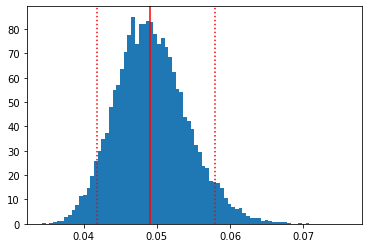

In [9]:
plt.hist(samples, bins='auto', density=True);
plt.axvline(p05,color='r',ls=':')
plt.axvline(p50,color='r',ls='-')
plt.axvline(p95,color='r',ls=':')


You can then project the fitted parameters into the observed space.

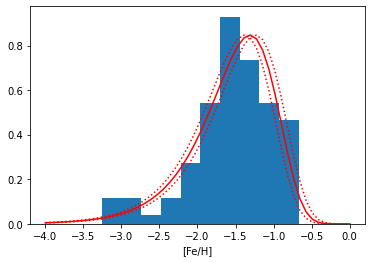

In [10]:
h,x,p = plt.hist(data, bins='auto', density=True)
plt.xlabel("[Fe/H]")
xplot = np.linspace(-4,0)
plt.plot(xplot, mdfmodels.leaky_box(xplot, p50), 'r-')
plt.plot(xplot, mdfmodels.leaky_box(xplot, p05), 'r:')
plt.plot(xplot, mdfmodels.leaky_box(xplot, p95), 'r:')

The traceplot shows the 1D posteriors and the time evolution of the values.
Note that samples are weighted and progress linearly from low to high -lnX.
The coloring shows where the typical set (i.e. most of the volume of the posterior) is.

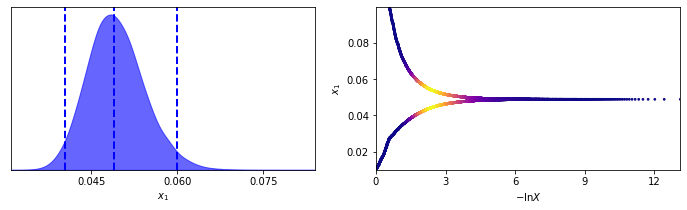

In [11]:
fig1 = dyplot.traceplot(res)

This is a standard corner plot that automatically accounts for the weights.

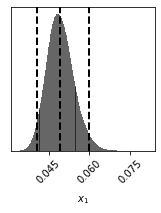

In [12]:
fig2 = dyplot.cornerplot(res)

# Fitting pre-enriched box

Let's use the same leaky box data and fit it using the pre enriched model.

In [13]:
# this step takes a minute or two because dynesty is kinda slow. There's ways to optimize that I haven't found yet
with MultiPool(4) as pool:
    output2 = fit.fit_pre_enriched_box(data, logpmin=-2, logpmax=-1,
                                       feh0min=-4, feh0max=-2,
                                       pool=pool)

0it [00:00, ?it/s]/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:31: RuntimeWarning: invalid value encountered in log
  out = np.log(np.log(10)) + np.log(z-z0) - z - np.log(np.exp(-z0) - z0 * (-special.expi(-z0)))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:31: RuntimeWarning: invalid value encountered in log
  out = np.log(np.log(10)) + np.log(z-z0) - z - np.log(np.exp(-z0) - z0 * (-special.expi(-z0)))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:31: RuntimeWarning: invalid value encountered in log
  out = np.log(np.log(10)) + np.log(z-z0) - z - np.log(np.exp(-z0) - z0 * (-special.expi(-z0)))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:31: RuntimeWarning: invalid value encountered in log
  out = np.log(np.log(10)) + np.log(z-z0) - z - np.log(np.exp(-z0) - z0 * (-special.expi(-z0)))
3912it [00:04, 1284.99it/s, batch: 0 | bound: 8 | nc: 1 | ncall: 20630 | eff(%): 18.514 | loglstar:   -inf < -73.128 <    inf | logz: -76.404 +/-    nan |

11015it [00:38, 313.83it/s, batch: 8 | bound: 0 | nc: 1 | ncall: 108346 | eff(%): 10.167 | loglstar: -79.081 < -73.154 < -73.442 | logz: -76.374 +/-    nan | stop:  1.127] /Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:31: RuntimeWarning: invalid value encountered in log
  out = np.log(np.log(10)) + np.log(z-z0) - z - np.log(np.exp(-z0) - z0 * (-special.expi(-z0)))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:31: RuntimeWarning: invalid value encountered in log
  out = np.log(np.log(10)) + np.log(z-z0) - z - np.log(np.exp(-z0) - z0 * (-special.expi(-z0)))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:31: RuntimeWarning: invalid value encountered in log
  out = np.log(np.log(10)) + np.log(z-z0) - z - np.log(np.exp(-z0) - z0 * (-special.expi(-z0)))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:31: RuntimeWarning: invalid value encountered in log
  out = np.log(np.log(10)) + np.log(z-z0) - z - np.log(np.exp(-z0) - z0 * (-special.expi(-z0)))


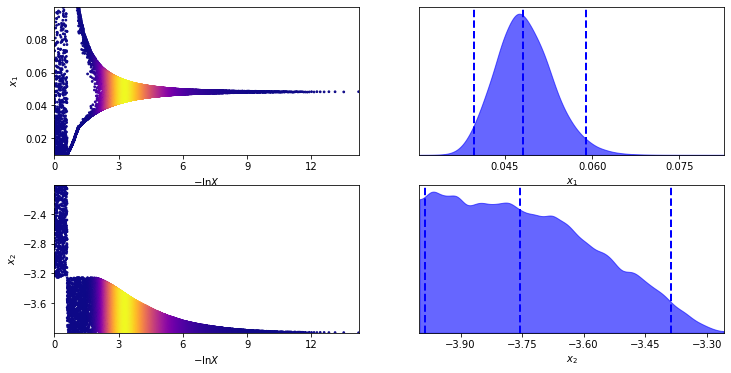

In [14]:
dyplot.traceplot(output2.results);

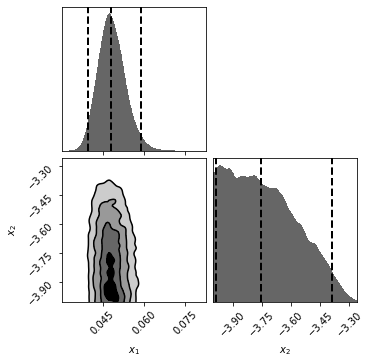

In [15]:
dyplot.cornerplot(output2.results);

You can see in the cornerplot that x2, which is feh0, is essentially an upper limit to be less than -3.3. This makes sense, because the pre-enriched box reduces to the leaky box when feh0 goes to -infinity (or at least less than the observations)

# Fitting Extra Gas model

Right now this is very slow. The issue is that there is no analytic form of the normalizing constant, and so you have to numerically integrate it every time.

I am going to try to precompute and interpolate to speed this up, but here's the code for now.

In [17]:
# this step took 4 hours, need to optimize this for sure.
with MultiPool(6) as pool:
    output3 = fit.fit_extra_gas(data, logpmin=-2, logpmax=-1,
                                Mmin=1, Mmax=3,
                                pool=pool)


0it [00:00, ?it/s]/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log10(

/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(

/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log10(p) + 2*np.log10(M)

/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log10
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log10(p) + 2*np.log10(M) - 2*np.log10(1+s-sM) + np.log10(-np.log(1-sM) - sM * (1-1/M))
/Users/alexji/lib/python/mdfmodels/mdfmodels/mdfmodels.py:37: RuntimeWarning: divide by zero encountered in log
  return np.log10(p) + 2*np.log10(M) -

In [22]:
# import pickle
# with open("fitexample_extra_gas_dresults.pkl","wb") as fp:
#     pickle.dump(output3.results,fp)

M=1 reduces the extra gas model back to the leaky box model, so this is all great!

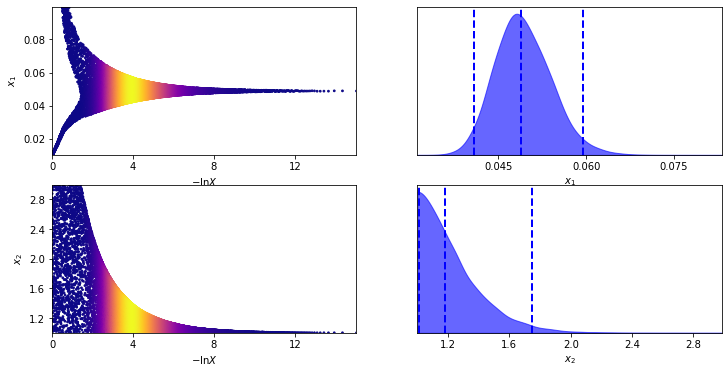

In [23]:
dyplot.traceplot(output3.results);

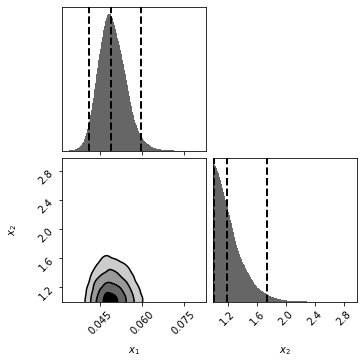

In [24]:
dyplot.cornerplot(output3.results);